In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_price = pd.read_csv(os.path.join('/home/inlabws/SY_TEST/keras_lstm', '5_samsung.csv'), encoding='utf8')
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-14,29700.0,29700.0,29300.0,29480.0,285.887604,9429750.0
1,2015-04-15,29200.0,29400.0,28540.0,28920.0,280.456970,13551050.0
2,2015-04-16,29240.0,29540.0,28940.0,29540.0,286.469482,10762350.0
3,2015-04-17,29540.0,29560.0,28940.0,29000.0,281.232727,10172300.0
4,2015-04-20,28920.0,28960.0,28460.0,28600.0,277.353668,12394900.0


In [2]:
pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
# 0      2020-01-07
# 1      2020-01-06
# 2      2020-01-03
# 3      2020-01-02
# 4      2019-12-30

df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
df_price['Year'] =df_price['Date'].dt.year
df_price['Month'] =df_price['Date'].dt.month
df_price['Day'] =df_price['Date'].dt.day

df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2015-04-14,29700.0,29700.0,29300.0,29480.0,285.887604,9429750.0,2015,4,14
1,2015-04-15,29200.0,29400.0,28540.0,28920.0,280.456970,13551050.0,2015,4,15
2,2015-04-16,29240.0,29540.0,28940.0,29540.0,286.469482,10762350.0,2015,4,16
3,2015-04-17,29540.0,29560.0,28940.0,29000.0,281.232727,10172300.0,2015,4,17
4,2015-04-20,28920.0,28960.0,28460.0,28600.0,277.353668,12394900.0,2015,4,20


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price')

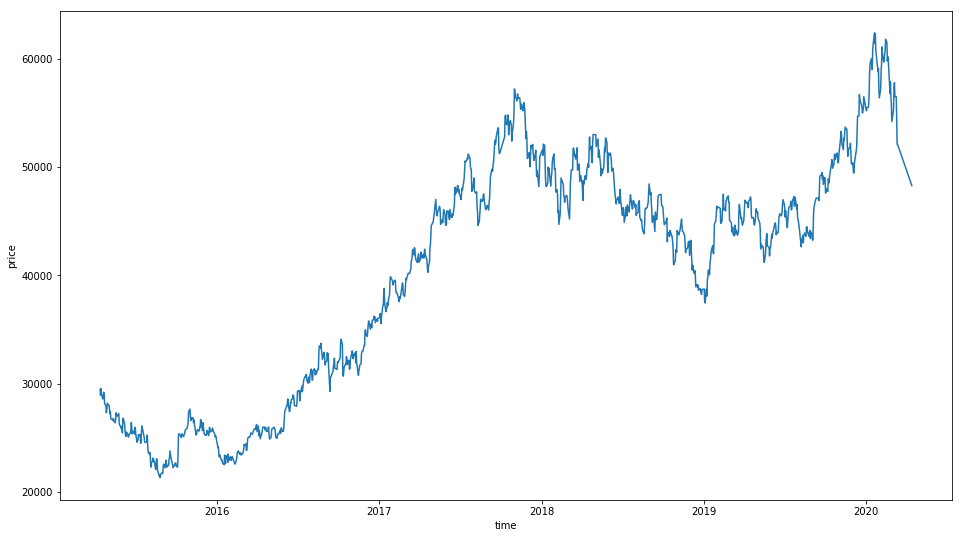

In [3]:
df = df_price.loc[df_price['Year']>=2015]

plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df['Date'])
plt.xlabel('time')
plt.ylabel('price')

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
df_scaled.dropna(inplace=True)
print(df_scaled)

          Open      High       Low     Close    Volume
0     0.205217  0.198935  0.210526  0.198246  0.145788
1     0.192913  0.191675  0.192008  0.184608  0.209505
2     0.193898  0.195063  0.201754  0.199708  0.166390
3     0.201280  0.195547  0.201754  0.186556  0.157268
4     0.186024  0.181026  0.190058  0.176814  0.191630
5     0.173720  0.179574  0.188596  0.183634  0.183247
6     0.185039  0.193127  0.196394  0.191914  0.195660
7     0.197835  0.191675  0.198343  0.187043  0.142934
8     0.187500  0.184414  0.178850  0.167073  0.295138
9     0.168307  0.163117  0.166667  0.159766  0.255362
10    0.158465  0.157793  0.158869  0.145641  0.242687
11    0.147146  0.154889  0.161306  0.154895  0.168451
12    0.156004  0.166505  0.168616  0.167073  0.283743
13    0.166831  0.168925  0.177388  0.162202  0.128069
14    0.158465  0.153437  0.157407  0.143692  0.205167
15    0.144685  0.145692  0.156433  0.147589  0.158584
16    0.146654  0.143272  0.148635  0.132002  0.146690
17    0.14

In [5]:
TEST_SIZE = 240
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

def make_dataset(data, label, window_size=15):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [6]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((220, 20, 4), (220, 1))

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from decimal import Decimal 

model = Sequential()
model.add(LSTM(24, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='tanh', 
               return_sequences=False)
          )
model.add(Dense(1))

Using TensorFlow backend.


In [8]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_path = '/home/inlabws/SY_TEST/keras_lstm/model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

hist = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid,y_valid), 
                    callbacks=[early_stop, checkpoint])



Train on 753 samples, validate on 189 samples
Epoch 1/200
753/753 [==============================] - 2s 3ms/step - loss: 0.0326 - val_loss: 0.0029

Epoch 00001: val_loss improved from inf to 0.00289, saving model to /home/inlabws/SY_TEST/keras_lstm/model/tmp_checkpoint.h5
Epoch 2/200
753/753 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0011

Epoch 00002: val_loss improved from 0.00289 to 0.00114, saving model to /home/inlabws/SY_TEST/keras_lstm/model/tmp_checkpoint.h5
Epoch 3/200
753/753 [==============================] - 1s 2ms/step - loss: 9.3252e-04 - val_loss: 0.0011

Epoch 00003: val_loss improved from 0.00114 to 0.00109, saving model to /home/inlabws/SY_TEST/keras_lstm/model/tmp_checkpoint.h5
Epoch 4/200
753/753 [==============================] - 1s 2ms/step - loss: 8.9395e-04 - val_loss: 0.0010

Epoch 00004: val_loss improved from 0.00109 to 0.00101, saving model to /home/inlabws/SY_TEST/keras_lstm/model/tmp_checkpoint.h5
Epoch 5/200
753/753 [====

753/753 [==============================] - 1s 2ms/step - loss: 4.7158e-04 - val_loss: 6.1616e-04

Epoch 00041: val_loss improved from 0.00063 to 0.00062, saving model to /home/inlabws/SY_TEST/keras_lstm/model/tmp_checkpoint.h5
Epoch 42/200
753/753 [==============================] - 1s 2ms/step - loss: 4.5283e-04 - val_loss: 7.4306e-04

Epoch 00042: val_loss did not improve from 0.00062
Epoch 43/200
753/753 [==============================] - 1s 2ms/step - loss: 4.8712e-04 - val_loss: 5.9828e-04

Epoch 00043: val_loss improved from 0.00062 to 0.00060, saving model to /home/inlabws/SY_TEST/keras_lstm/model/tmp_checkpoint.h5
Epoch 44/200
753/753 [==============================] - 1s 2ms/step - loss: 5.0128e-04 - val_loss: 5.9935e-04

Epoch 00044: val_loss did not improve from 0.00060
Epoch 45/200
753/753 [==============================] - 1s 2ms/step - loss: 4.7045e-04 - val_loss: 6.0173e-04

Epoch 00045: val_loss did not improve from 0.00060
Epoch 46/200
753/753 [=========================

Epoch 83/200
753/753 [==============================] - 1s 2ms/step - loss: 3.8679e-04 - val_loss: 5.5486e-04

Epoch 00083: val_loss did not improve from 0.00049
Epoch 84/200
753/753 [==============================] - 1s 2ms/step - loss: 4.2443e-04 - val_loss: 4.8582e-04

Epoch 00084: val_loss improved from 0.00049 to 0.00049, saving model to /home/inlabws/SY_TEST/keras_lstm/model/tmp_checkpoint.h5
Epoch 85/200
753/753 [==============================] - 1s 2ms/step - loss: 3.6281e-04 - val_loss: 4.8011e-04

Epoch 00085: val_loss improved from 0.00049 to 0.00048, saving model to /home/inlabws/SY_TEST/keras_lstm/model/tmp_checkpoint.h5
Epoch 86/200
753/753 [==============================] - 1s 2ms/step - loss: 3.8131e-04 - val_loss: 5.1997e-04

Epoch 00086: val_loss did not improve from 0.00048
Epoch 87/200
753/753 [==============================] - 1s 2ms/step - loss: 3.7036e-04 - val_loss: 4.7788e-04

Epoch 00087: val_loss improved from 0.00048 to 0.00048, saving model to /home/inlabws

In [9]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

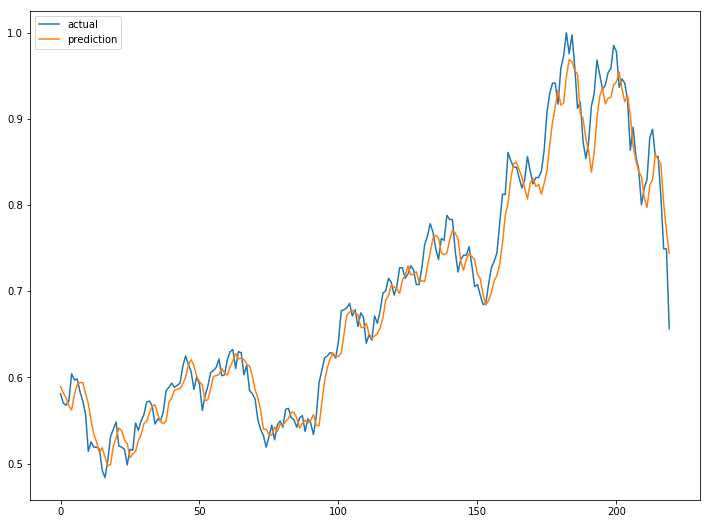

In [10]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()